In [1]:
import torch as th
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from papersim.sim import GoodFlowSim
from papersim.modules.risk_generator import Risk, RiskGen
from papersim.modules.sim_modules import ProductionModule, TransportModule

In [3]:
prod_matrix = th.tensor(np.array([[0, 0, 0, 0],
                                  [0, 0, 0, 0],
                                  [1, 1, 0, 0],
                                  [0, 0, 1, 0]]), dtype=th.int32)

mod_a = ProductionModule(0, 0, 0, prod_matrix[0], 10)
mod_b = ProductionModule(1, 1, 1, prod_matrix[1], 10)
mod_c = ProductionModule(2, 2, 2, prod_matrix[2], 10)
mod_d = ProductionModule(3, 3, 3, prod_matrix[3], 10)

tra_ac = TransportModule(4, 0, 0, 0, 2, 10)
tra_bc = TransportModule(5, 1, 1, 1, 2, 10)
tra_cd = TransportModule(6, 2, 2, 2, 3, 10)

prod_mods = [mod_a, mod_b, mod_c, mod_d]
trans_mods = [tra_ac, tra_bc, tra_cd]

risks = [Risk(0.01, 0.5, 50, [0]),  # Software brakedown, once a year
         Risk((1 / 7) * 1e-5, 0.2, 1, [1]),  #
         Risk(0.1, 0.2, 5, [2, 3]),
         Risk(0.002, 0.9, 30, [0, 1, 4]),
         Risk(0.02, 0.3, 1, [2, 3]),
         Risk(0.1, 0.05, 10, [1, 2]),
         ]

In [6]:
loss_f0 = lambda a, b: a - b
loss_f1 = lambda a, b: 0 if a == b else 1
loss_f2 = lambda a, b: (a - b)^2
loss_fs = [loss_f0, loss_f1, loss_f2]

t_run = 1000
num_results = 2

sim = GoodFlowSim(prod_mods, trans_mods, risks, 4, num_runs=num_results, device='cpu')
inv, prod, loss = sim.run(t_run, loss_f0)

Storage
0


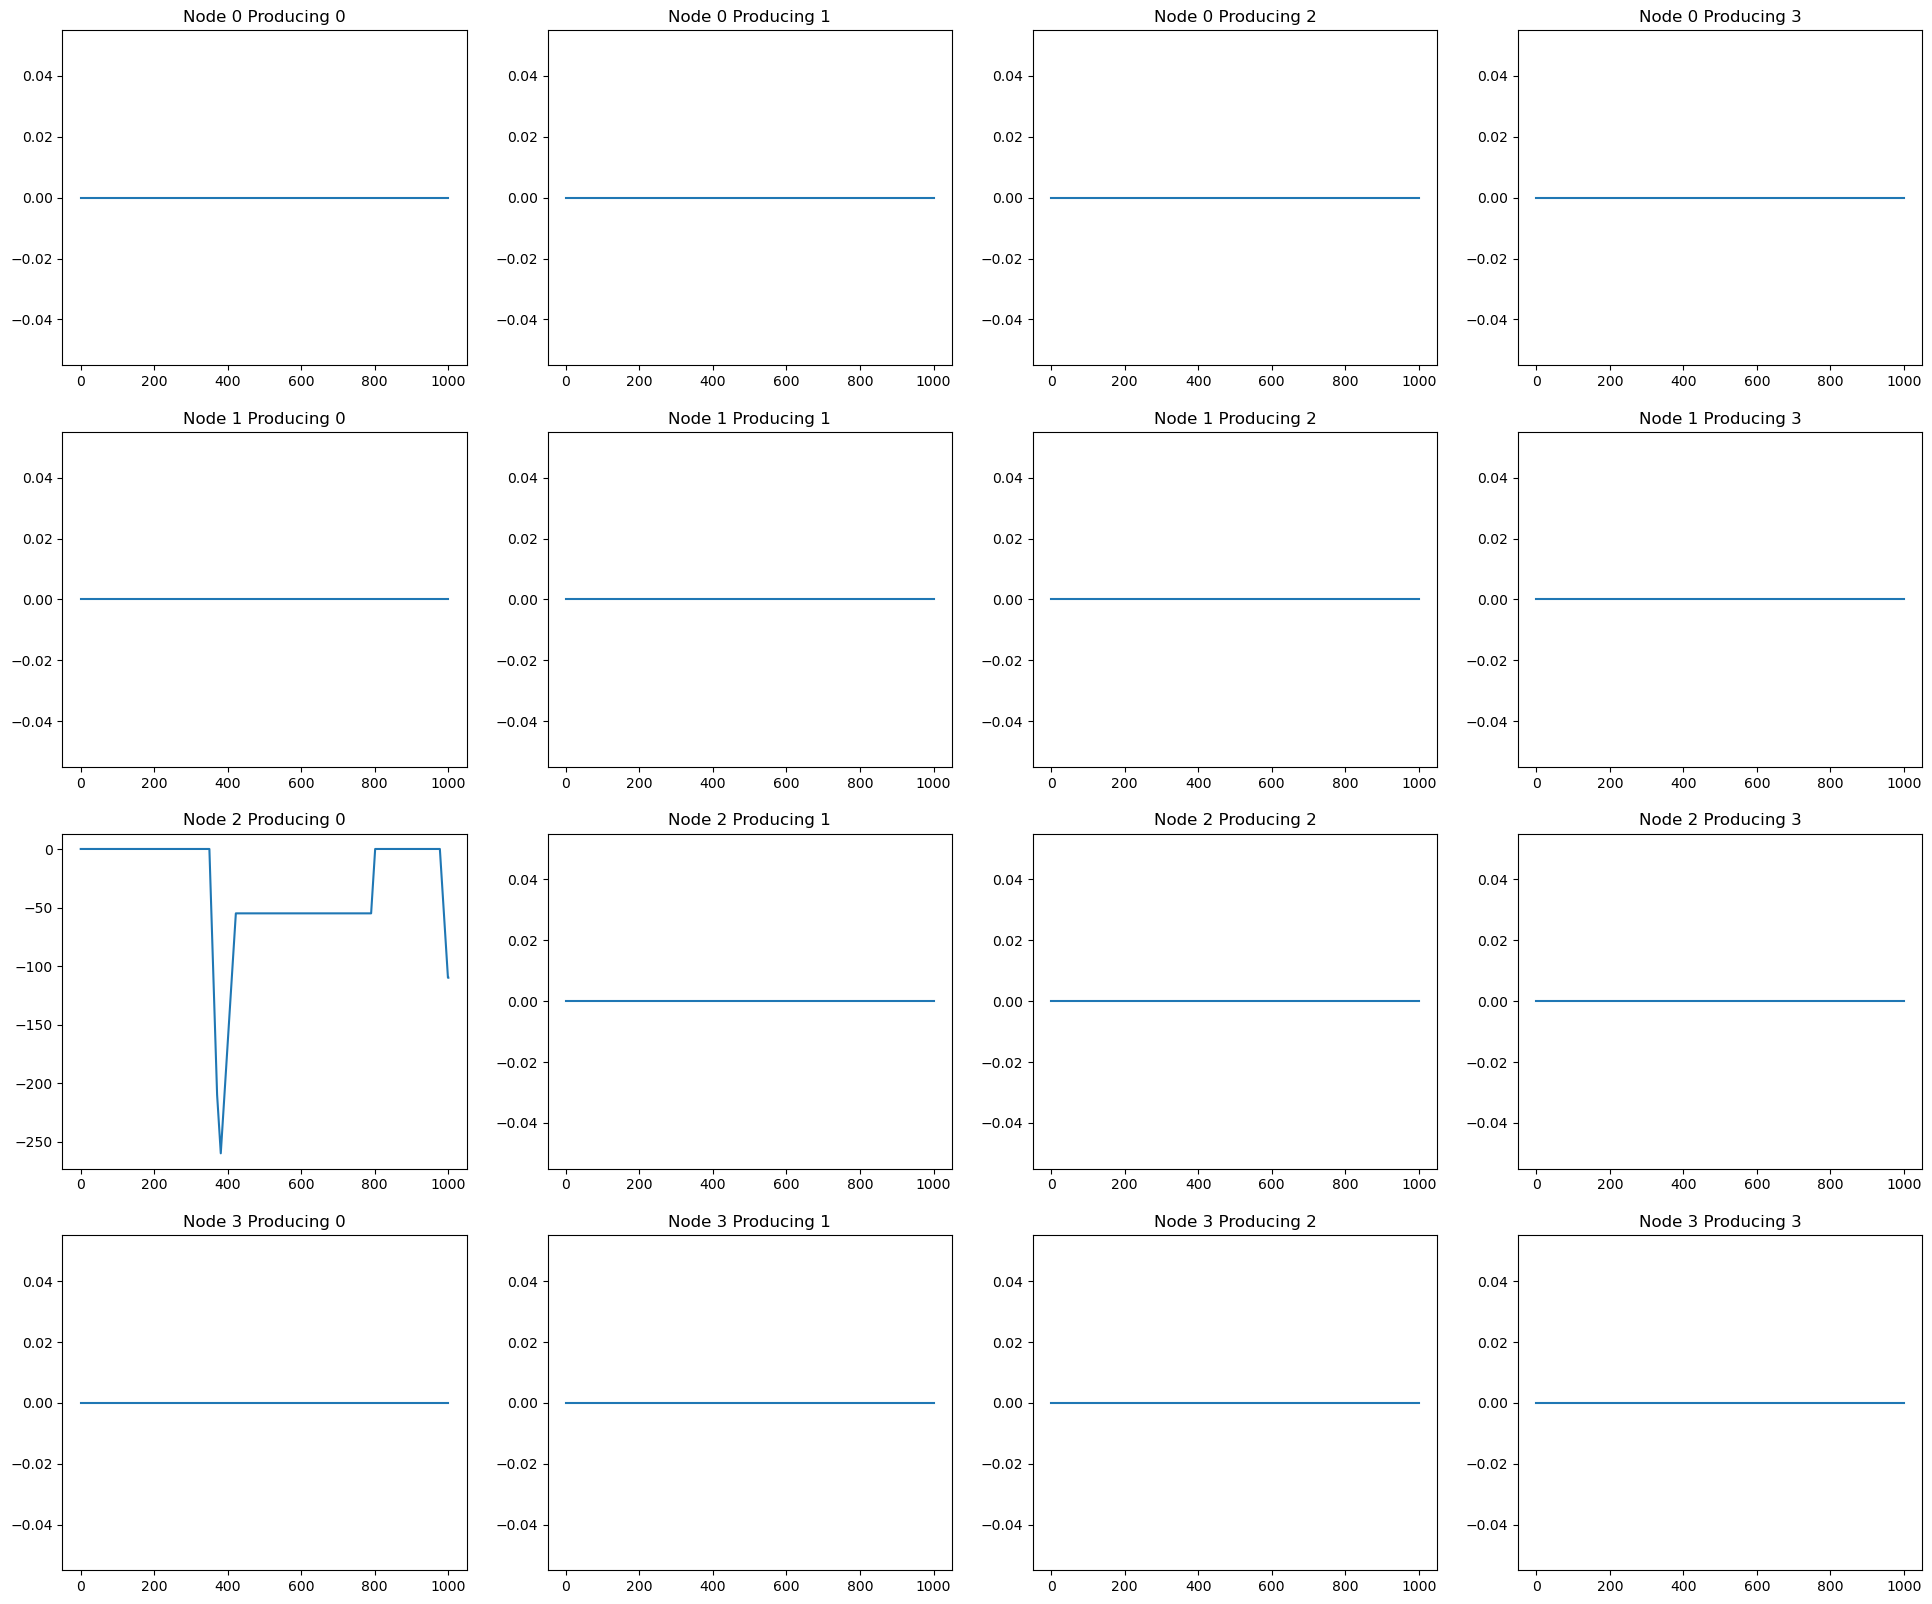

1


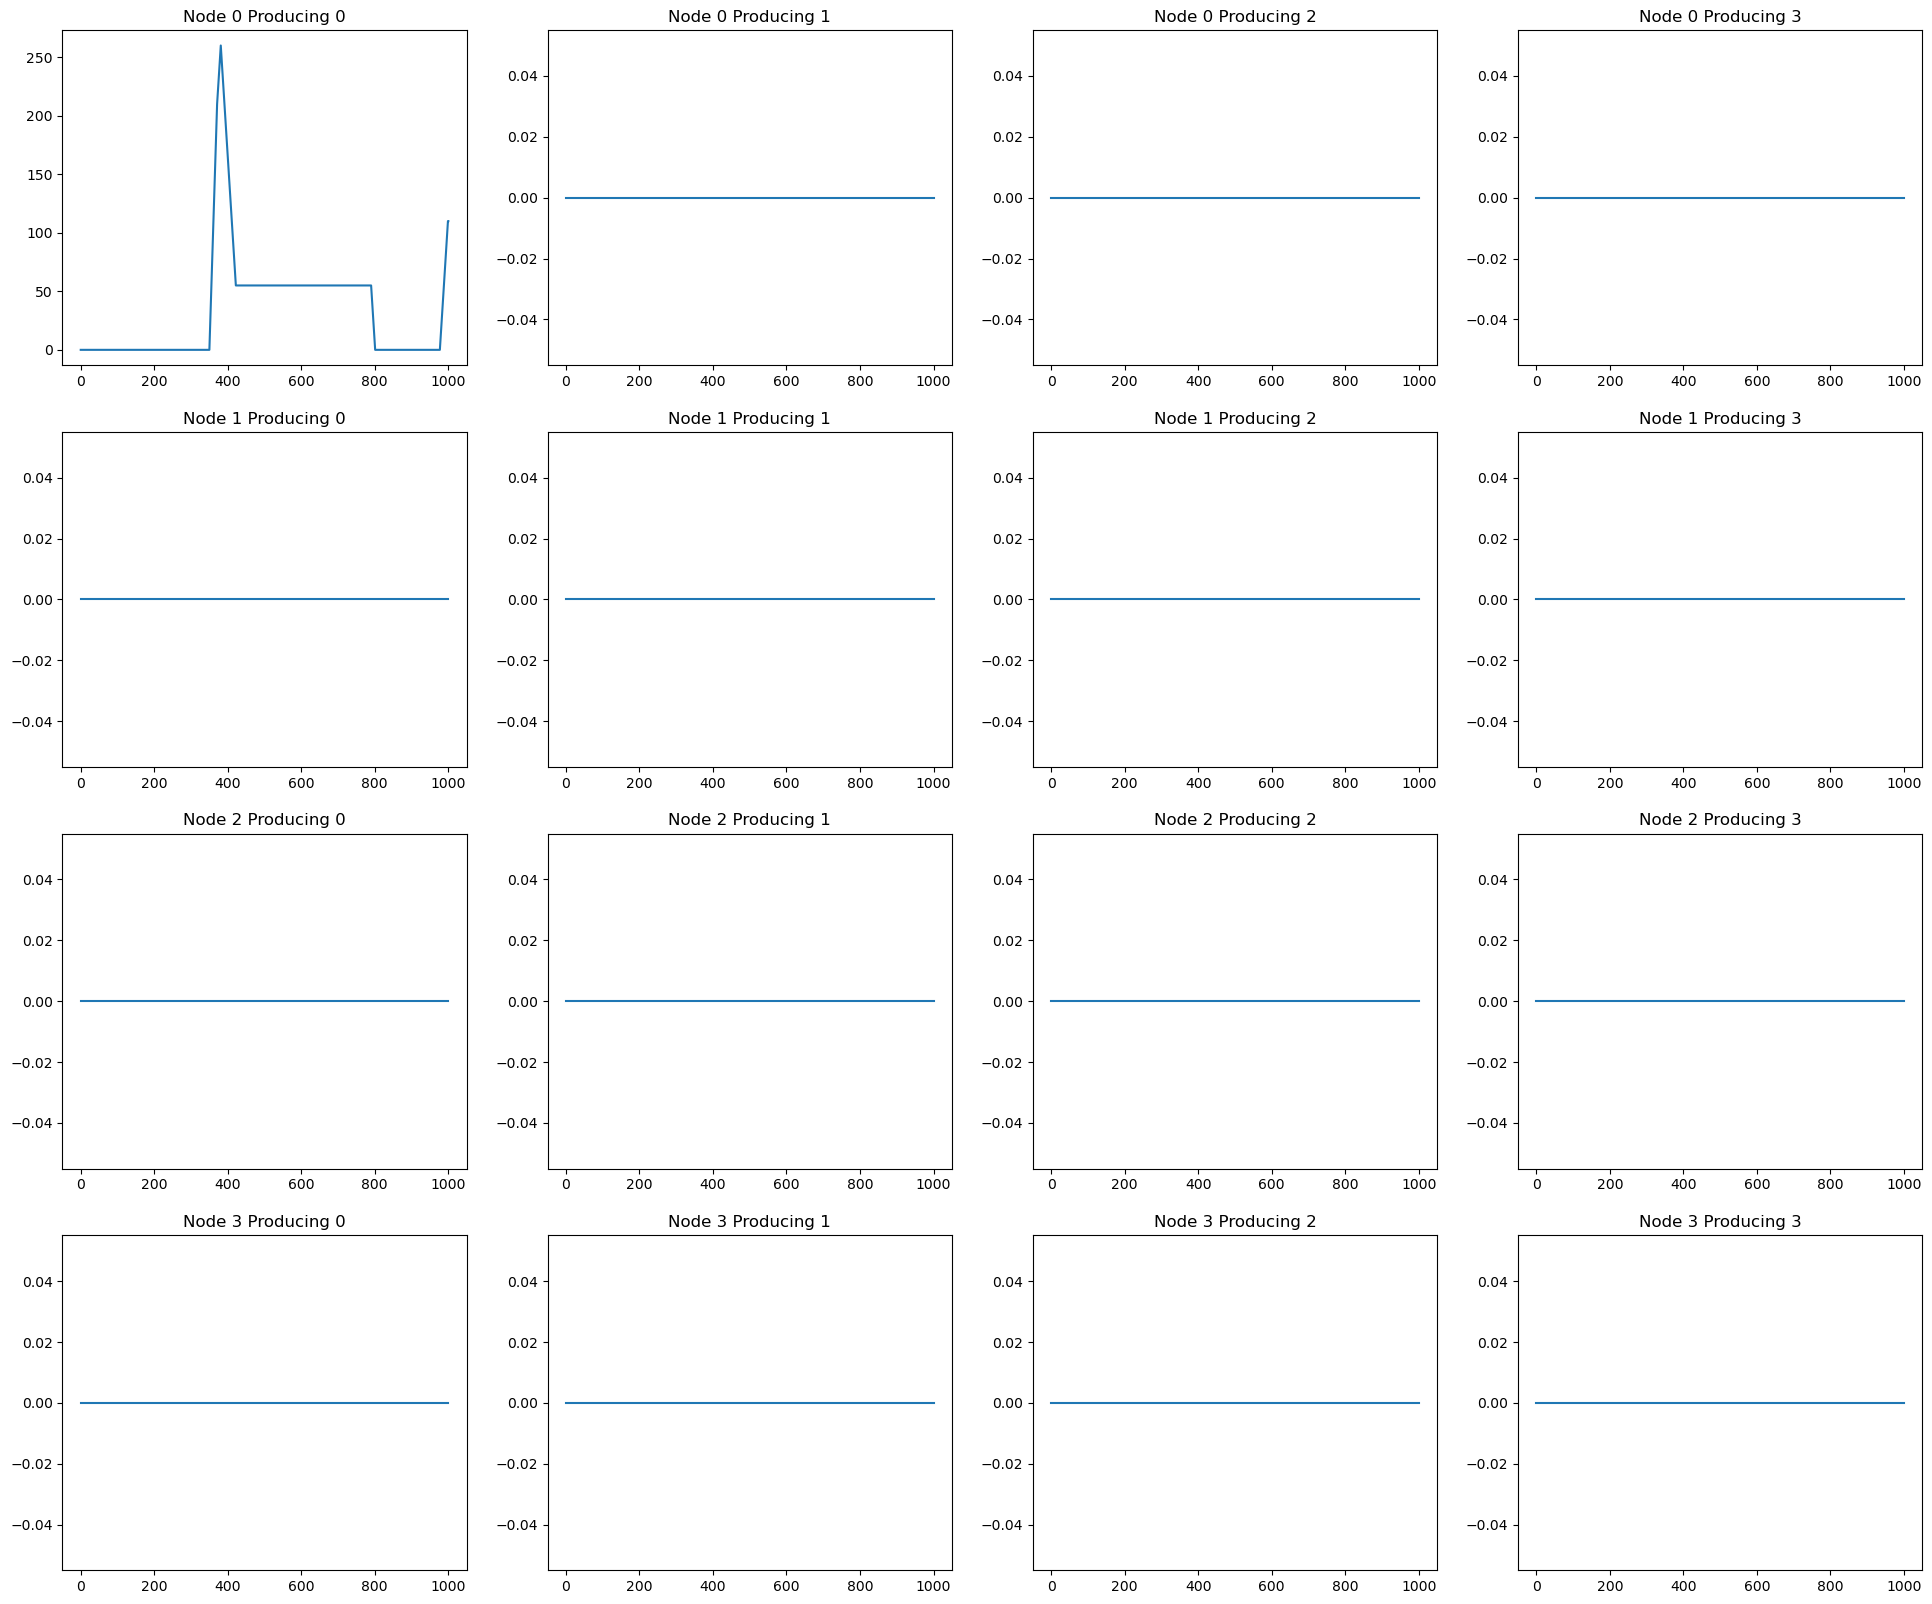

Production


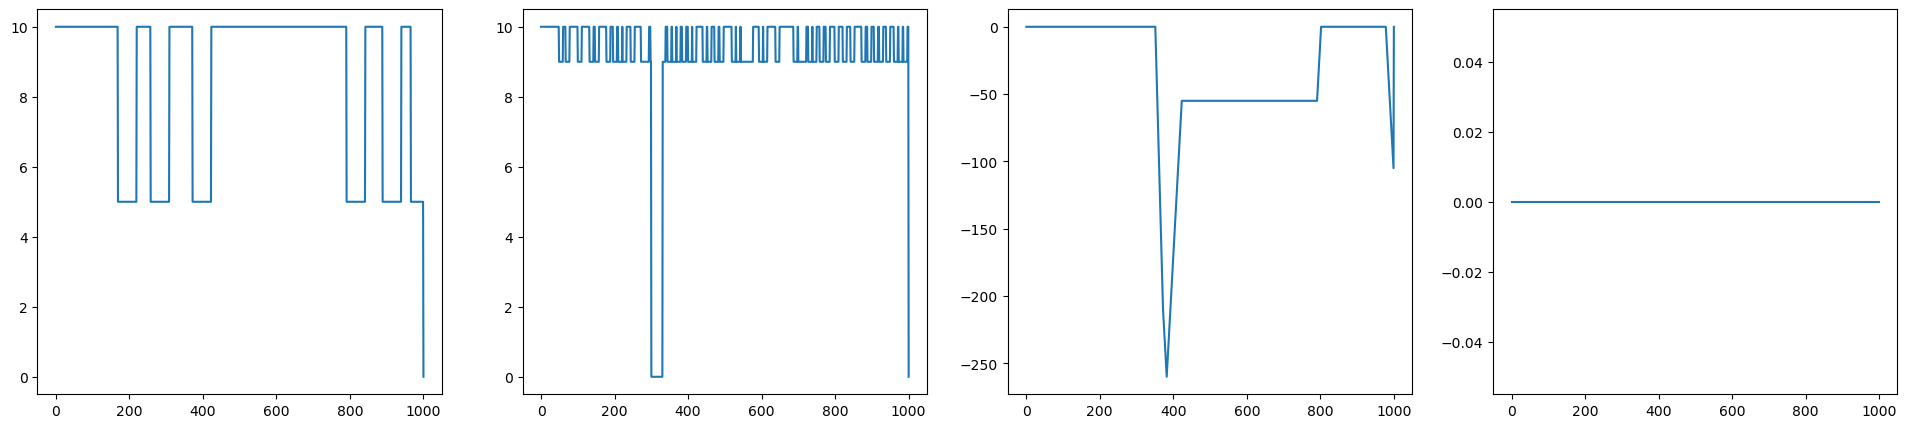

In [7]:
print('Storage')

for k in range(2):
    print(k)
    fig, axs = plt.subplots(inv.shape[-2], inv.shape[-1], figsize=(24, 20))
    for i in range(inv.shape[-2]):
        for j in range(inv.shape[-1]):
            axs[i, j].plot(inv[:, 0, k, i, j])
            axs[i, j].set_title("Node " + str(i) + ' Producing ' + str(j))

    plt.show()

print('Production')

fig, axs = plt.subplots(1, prod.shape[-1], figsize=(24, 5))

for i in range(prod.shape[-1]):
    axs[i].plot(prod[:, 0, i])

plt.show()
#
# print('Transport')
#
# fig, axs = plt.subplots(1, trans.shape[-1], figsize=(24, 5))
#
# for i in range(trans.shape[-1]):
#     axs[i].plot(trans[:, 0, i])
#
# plt.show()
#
# fig, axs = plt.subplots(1, 1, figsize=(24, 5))
#
# axs.plot(loss)
#
# plt.show()